In [ ]:
IN_COLAB = 'google.colab' in str(get_ipython())

In [ ]:
if IN_COLAB:
  # Uninstall tensorflow first
  !pip uninstall tensorflow -y
  # Install tensorflow-gpu (stable version)
  !pip install tensorflow-gpu  # stable
  !pip install emoji
  import tensorflow as tf
  # Check version
  print(tf.__version__)

  from tensorflow.python.client import device_lib
  device_lib.list_local_devices()

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

2.4.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import re
import string
import os
import emoji

import collections
import unicodedata


from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pprint import pprint
from time import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, wordnet

from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

In [ ]:
def get_filepath(foldername,filename):
  
  if IN_COLAB:
      from google.colab import drive
      drive.mount('/content/drive')
      data_path = 'drive/My Drive/datasets/{foldername}/{filename}'
      source_path = Path.cwd()
      return source_path.joinpath(data_path.format(foldername=foldername,filename=filename))
  else:
      data_path='{filename}'
      source_path =Path.cwd().joinpath('datasource')
      return source_path.joinpath(data_path.format(filename=filename))

In [ ]:
foldername = 'SentimentalAnalysis_II'
train_file = get_filepath(foldername,'train.csv')
test_file  = get_filepath(foldername,'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(train_file)

In [ ]:
test_df = pd.read_csv(test_file)

In [ ]:
train_df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [ ]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [ ]:

sk_learn_stopwords = text.ENGLISH_STOP_WORDS
nltk__stopwords = stopwords.words('english')
stop_words = sk_learn_stopwords.intersection(nltk__stopwords)

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):
    other_stopwords = [
        'pic.twitter.com', 'android', 'apple', 'appl', 'samsung', 'sony',
        'galaxy', 'ipad', 'iphone', 'iphon', 'iphones', 'iphonex', 'ipod',
        'itune', 'itun', 'itunes'
        'phone', 'phon', 'twit', 'twitter',
        'soni', 'xperia', 'experia',
    ]

    def __init__(self, stop_words, stemmer):
        self.stop_words = stop_words
        self.stemmer = stemmer
        self.tokenizer = TweetTokenizer()

    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)

    def remove_accented_chars(self, input_text):
        text = unicodedata.normalize('NFKD', input_text).encode(
            'ascii', 'ignore').decode('utf-8', 'ignore')
        return text

    def remove_urls(self, input_text):
        input_text = re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
        input_text = re.sub(r'^RT[\s]+', '', input_text)
        for other_stopword in self.other_stopwords:
            if other_stopword == 'pic.twitter.com':
                other_stopword = other_stopword + '(.*)'
            input_text = re.sub(other_stopword, '', input_text)
        return input_text

    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_', '')

    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(
            punct,
            len(punct) *
            ' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)

    def to_lower(self, input_text):
        return input_text.lower()

    def remove_stopwords(self, input_text):

        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = self.tokenizer.tokenize(input_text)
        clean_words = [
            word for word in words
            if ((word.strip() not in self.stop_words and word.strip() not in self.other_stopwords) or word.strip() in whitelist)
        ]
        clean_words = [CONTRACTION_MAP.get(word, word) for word in clean_words]
        return " ".join(clean_words)

    def remove_repeated_characters(self, input_text):

        repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
        match_substitution = r'\1\2\3'
        tokens = input_text.split()

        def replace(old_word):
            if wordnet.synsets(old_word):
                return old_word
            new_word = repeat_pattern.sub(match_substitution, old_word)
            return replace(new_word) if new_word != old_word else new_word

        correct_tokens = [replace(word) for word in tokens]

        return " ".join(correct_tokens)

    def remove_shortwords(self, input_text):
        words = self.tokenizer.tokenize(input_text)
        words = [word for word in words if 2 < len(word) < 20]
        return " ".join(words)

    def stemming(self, input_text):
        words = self.tokenizer.tokenize(input_text)
        if isinstance(self.stemmer, WordNetLemmatizer):
            stemmed_words = [self.stemmer.lemmatize(word) for word in words]
        else:
            stemmed_words = [self.stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_accented_chars)
        clean_X = clean_X.apply(self.remove_mentions)
        clean_X = clean_X.apply(self.remove_urls)
        clean_X = clean_X.apply(self.emoji_oneword)
        clean_X = clean_X.apply(self.remove_stopwords)
        clean_X = clean_X.apply(self.remove_punctuation)
        clean_X = clean_X.apply(self.remove_digits)
        clean_X = clean_X.apply(self.remove_repeated_characters)
        clean_X = clean_X.apply(self.to_lower)

        clean_X = clean_X.apply(self.remove_shortwords)

        #clean_X = clean_X.apply(self.stemming)
        #clean_X = clean_X.apply(self.remove_shortwords)
        return clean_X

In [ ]:
stemmer = PorterStemmer()
ct = CleanText(stop_words, stemmer)
train_df['clean_tweet'] = ct.fit_transform(train_df['tweet'])
test_df['clean_tweet'] = ct.transform(test_df['tweet'])

In [ ]:
train_df.head()

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test aps beautiful cute ...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,love would talk makememories unplug relax smar...
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george made way cute daventry home
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple will not even talk ...


In [ ]:
MAX_TWEET_LEN  = max(max(train_df['clean_tweet'].map(len)),max(test_df['clean_tweet'].map(len)))  

In [ ]:
MAX_TWEET_LEN

230

In [ ]:
tweets = train_df['clean_tweet'].values

In [ ]:
tweets

array(['fingerprint pregnancy test aps beautiful cute health igers only sia',
       'finally transparant silicon case thanks uncle yay sony xperia',
       'love would talk makememories unplug relax smarte wifi connect',
       ...,
       'helping lovely year old neighbor ipad morning just made realise not actually need pad',
       'finally got smart pocket wifi stay connected anytime anywhere gadget',
       'apple barcelona apple store bcn barcelona travel selfie fly fun cabincrew'],
      dtype=object)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweets)
padded_sequence = pad_sequences(encoded_docs, maxlen=MAX_TWEET_LEN)

In [ ]:
print(tweets[0])
print(encoded_docs[0])

fingerprint pregnancy test aps beautiful cute health igers only sia
[1973, 1137, 52, 31, 16, 87, 66, 60, 75]


In [ ]:
from keras.callbacks import ModelCheckpoint
model_filename = 'tweets_best_weights_'+str(int(dt.utcnow().timestamp()*100))+'.hdf5'
filepath = get_filepath(foldername,filename=model_filename)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout,Bidirectional
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 10
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=MAX_TWEET_LEN) )
model.add(SpatialDropout1D(0.25))
#model.add(LSTM(12, dropout=0.25, recurrent_dropout=0.25))
model.add(Bidirectional(LSTM(24,dropout=0.5,recurrent_dropout=0.3)))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 230, 10)           144030    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 230, 10)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 48)                6720      
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 49        
Total params: 150,799
Trainable params: 150,799
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_history = model.fit(padded_sequence,train_df['label'].values,
                  validation_split=0.35, epochs=5, batch_size=32,callbacks=callbacks_list)

Epoch 1/5
161/161 [==============================] - 59s 334ms/step - loss: 0.6086 - accuracy: 0.7172 - val_loss: 0.4968 - val_accuracy: 0.7413

Epoch 00001: val_accuracy improved from -inf to 0.74134, saving model to /content/drive/My Drive/datasets/SentimentalAnalysis_II/tweets_best_weights_161079727287.hdf5
Epoch 2/5
161/161 [==============================] - 52s 325ms/step - loss: 0.3966 - accuracy: 0.7960 - val_loss: 0.2945 - val_accuracy: 0.8730

Epoch 00002: val_accuracy improved from 0.74134 to 0.87302, saving model to /content/drive/My Drive/datasets/SentimentalAnalysis_II/tweets_best_weights_161079727287.hdf5
Epoch 3/5
161/161 [==============================] - 53s 328ms/step - loss: 0.2642 - accuracy: 0.8950 - val_loss: 0.2650 - val_accuracy: 0.8864

Epoch 00003: val_accuracy improved from 0.87302 to 0.88636, saving model to /content/drive/My Drive/datasets/SentimentalAnalysis_II/tweets_best_weights_161079727287.hdf5
Epoch 4/5
161/161 [==============================] - 53s 3

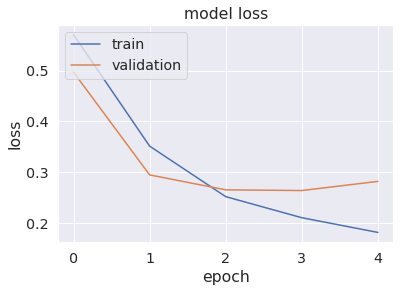

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

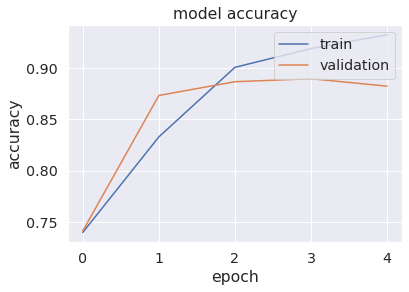

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model.load_weights(filepath)

In [ ]:
test_tweet = test_df['clean_tweet'].values
encoded_docs = tokenizer.texts_to_sequences(test_tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=MAX_TWEET_LEN)

In [ ]:
y_pred = model.predict_classes(padded_sequence)

In [ ]:
y_pred =y_pred.flatten()

In [ ]:
submission_df = pd.DataFrame(test_df['id'])

In [ ]:
submission_df['label'] =y_pred

In [ ]:
filename  = 'submission_tweet'+str(int(dt.utcnow().timestamp()*100)) +'.csv' 
filename

In [ ]:
submission_file = get_filepath(foldername,filename=filename)

In [ ]:
submission_df.to_csv(submission_file,index=False)